In [1]:
import geopandas
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import intersection
import settings
import nuts
import plots

# Load environmental zones by Metzger et al. (2008)

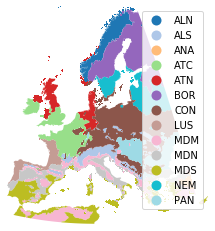

In [2]:
enz_geo = (
    geopandas
    .read_file(settings.ENZ_GIS_PATH)
    .set_index('EnZ_name')
    [["geometry"]]
)
ax = enz_geo.reset_index().plot('EnZ_name', cmap='tab20', legend=True).axes
plots.adj_geoplot(ax)

# Load NUTS regions GIS data

In [3]:
relevant_nuts_regions = (
    nuts.get_nuts_codes()
    .loc[lambda d: d.nuts_level <= 2]
    .index
)

In [4]:
nuts_geo = (
    geopandas
    .read_file(settings.NUTS_GIS_PATH)
    .set_index('NUTS_ID')
    .reindex(relevant_nuts_regions)
)

# Read permanent grassland yield data from Smit et al. (2008)

In [5]:
enz_yield = pd.read_csv(settings.GRASSLAND_YIELD_ENZ_PATH, index_col=['EnZ_name'])
enz_yield

,EnZ_label,yield
EnZ_name,,
ALN,Alpine North,4.04
BOR,Boreal,3.09
NEM,Nemoral,3.36
ATN,Atlantic North,7.42
ALS,Alpine South,3.25
CON,Continental,4.29
ATC,Atlantic Central,6.96
PAN,Pannonian,1.90
LUS,Lusitatnian,5.20


# Calculate share of each environmental zone in each NUTS region

In [6]:
enz_shares = intersection.get_share(enz_geo, nuts_geo)
enz_shares

EnZ_name  geo 
ALN       FI      0.080702
          FI1     0.080956
          FI1D    0.119971
          PL      0.000617
          PL2     0.007011
                    ...   
PAN       SK      0.233122
          SK0     0.233122
          SK01    0.685550
          SK02    0.505360
          SK03    0.151441
Name: share, Length: 921, dtype: float64

In [7]:
# Sanity check: shares should add up to about 100% in each region
enz_shares.groupby("geo").sum().describe()

count    387.000000
mean       0.997174
std        0.008911
min        0.859895
25%        0.997496
50%        1.000000
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [8]:
# The only seeming problem is France
bad_coverage = enz_shares.groupby("geo").sum().loc[lambda s: s < 0.9]
bad_coverage

geo
FR    0.859895
Name: share, dtype: float64

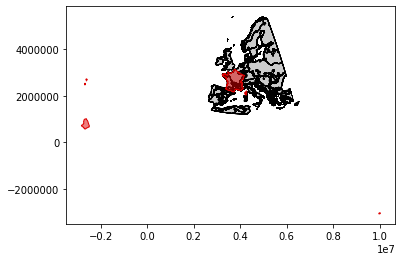

In [9]:
# The bad coverage of "France" is not in France proper but in French Guiana etc
ax = enz_geo.plot(color='#cccccc', edgecolor='k').axes
nuts_geo.loc[bad_coverage.index].plot(color='#dd000080', edgecolor='#dd0000', ax=ax)

In [10]:
# To deal with the few NUTS regions that are only ~97% covered by environmental zones,
# calculate weights that by definition add up to 100% in each NUTS region.
enz_weights = (
    enz_shares
    .groupby('geo')
    .apply(lambda s: s / s.sum())
)
enz_weights.groupby('geo').sum().describe().round(5)

count    387.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share, dtype: float64

In [11]:
enz_weights.to_csv(settings.ENZ_WEIGHTS_PATH, header=True)

# Calculate grassland yield as weighted average of environmental zones

In [12]:
nuts_yield = (
    enz_yield['yield']
    .mul(enz_weights)
    .groupby('geo')
    .sum()
    .rename('yield')
)
nuts_yield

geo
AT      3.531599
AT1     3.292787
AT11    2.577387
AT12    3.470497
AT13    1.900000
          ...   
UKM3    7.420000
UKM5    7.420000
UKM6    7.420000
UKN     7.418464
UKN0    7.418464
Name: yield, Length: 387, dtype: float64

# Inspect to see that datasets look similar

/home/rasmus/.local/share/virtualenvs/eu-p-budget-YA21ty_Y/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


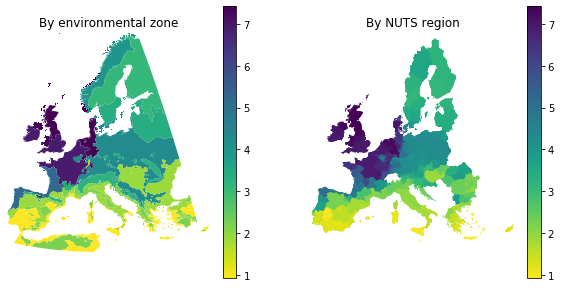

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

data = {
    'By environmental zone': enz_geo.join(enz_yield),
    'By NUTS region': nuts_geo.join(nuts_yield).dropna(),
}

for (title, d), ax in zip(data.items(), axs):
    d.plot('yield', cmap='viridis_r', legend=True, ax=ax)
    ax.set_title(title)
    plots.adj_geoplot(ax)

In [14]:
nuts_yield.to_csv(settings.GRASSLAND_YIELD_NUTS_PATH, header=True)